# Imports

In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import resample
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    classification_report
)
import pickle

# Data Loading

In [ ]:
data = joblib.load("data_splits.pkl")

X_train = data["X_train"]
X_val = data["X_val"]
X_test = data["X_test"]
y_train = data["y_train"]
y_val = data["y_val"]
y_test = data["y_test"]

# Decision Tree

In [ ]:
class DecisionTreeNode:
    """Class for a decision tree node."""
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.root = None

    def train(self, data, labels):
        """Initialize training by building the tree."""
        self.root = self._fit(data, labels, depth=0)

    def _fit(self, data, labels, depth):
        """Recursively builds the decision tree."""
        if depth == self.max_depth or len(np.unique(labels)) == 1:
            # Stop if max depth reached or node is pure
            return DecisionTreeNode(value=np.bincount(labels).argmax())

        best_feature, best_threshold = self._best_split(data, labels)

        if best_feature is None or best_threshold is None:
            # Stop if no good split is found
            return DecisionTreeNode(value=np.bincount(labels).argmax())

        left_mask = data[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        if np.all(left_mask) or np.all(right_mask):
            # Prevent infinite splitting
            return DecisionTreeNode(value=np.bincount(labels).argmax())

        left_child = self._fit(data[left_mask], labels[left_mask], depth + 1)
        right_child = self._fit(data[right_mask], labels[right_mask], depth + 1)

        return DecisionTreeNode(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)

    def _best_split(self, data, labels):
        """Finds the best feature and threshold for splitting."""
        best_info_gain = -1
        best_feature = None
        best_threshold = None

        num_features = data.shape[1]

        for feature_index in range(num_features):
            info_gain, threshold = self._compute_information_gain(data, feature_index, labels)
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_feature = feature_index
                best_threshold = threshold

        return best_feature, best_threshold

    def _compute_information_gain(self, data, feature_index, labels):
        """Computes the best info gain and threshold for a feature."""
        parent_entropy = self._entropy(labels)

        unique_values = np.unique(data[:, feature_index])
        best_info_gain = -1
        best_threshold = None

        for i in range(len(unique_values) - 1):
            threshold = (unique_values[i] + unique_values[i + 1]) / 2
            left_mask = data[:, feature_index] <= threshold
            right_mask = ~left_mask

            left_entropy = self._entropy(labels[left_mask])
            right_entropy = self._entropy(labels[right_mask])

            weighted_entropy = (
                (np.sum(left_mask) / len(labels)) * left_entropy +
                (np.sum(right_mask) / len(labels)) * right_entropy
            )
            info_gain = parent_entropy - weighted_entropy

            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_threshold = threshold

        return best_info_gain, best_threshold

    def _entropy(self, labels):
        """Computes entropy of a label set."""
        unique_labels, counts = np.unique(labels, return_counts=True)
        probabilities = counts / len(labels)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy

    def _predict_single(self, x, node):
        """Predict label for one sample."""
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_single(x, node.left)
        else:
            return self._predict_single(x, node.right)

    def predict(self, X):
        """Predict labels for a dataset."""
        return np.array([self._predict_single(x, self.root) for x in X])

    def predict_prob(self, X):
        """Return probability estimates for each input sample."""
        return np.array([self._predict_proba_single(x, self.root) for x in X])

    def predict_prob_single(self, x, node):
        """Traverse the tree to compute class probabilities at leaf."""
        if node.value is not None:
            # Return a probability distribution (for binary classification)
            proba = np.zeros(2)
            proba[node.value] = 1.0
            return proba

        if x[node.feature] <= node.threshold:
            return self.predict_prob_single(x, node.left)
        else:
            return self.predict_prob_single(x, node.right)

# Random Forest Model

In [ ]:
class RandomForest:
    def __init__(self, n_estimators=10, max_depth=3, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def _select_features(self, X):
        n_features = X.shape[1]
        if self.max_features is None:
            return np.arange(n_features)
        elif isinstance(self.max_features, int):
            return np.random.choice(n_features, self.max_features, replace=False)
        elif isinstance(self.max_features, float):
            count = max(1, int(self.max_features * n_features))
            return np.random.choice(n_features, count, replace=False)
        else:
            raise ValueError("Invalid value for max_features")

    def train(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            # Bootstrap sampling
            X_sample, y_sample = resample(X, y)

            # Feature subspace selection
            selected_features = self._select_features(X_sample)
            X_sub = X_sample[:, selected_features]

            tree = DecisionTree(max_depth=self.max_depth)
            tree.train(X_sub, y_sample)
            self.trees.append((tree, selected_features))

    def _predict_single(self, x):
        predictions = []
        for tree, features in self.trees:
            x_sub = x[features]
            prediction = tree._predict_single(x_sub, tree.root)
            predictions.append(prediction)
        return Counter(predictions).most_common(1)[0][0]

    def predict(self, X):
        return np.array([self._predict_single(x) for x in X])

    def predict_prob(self, X):
        """Returns average probability estimates for each input sample (binary classification)."""
        all_probs = []
        for tree, features in self.trees:
            probas = np.array([tree.predict_prob_single(x[features], tree.root) for x in X])
            all_probs.append(probas)
        mean_probs = np.mean(all_probs, axis=0)
        return mean_probs

# Hyperparameter Tuning

In [ ]:
# Hyperparameter options
n_estimators_options = [3, 5, 7]
max_depth_options = [2, 4, 6]

# Tracking best model
best_model = None
best_accuracy = 0
best_params = {}

for n_estimators in n_estimators_options:
    for max_depth in max_depth_options:
        model = RandomForest(n_estimators=n_estimators, max_depth=max_depth)
        model.train(X_train.values, y_train.values)

        y_pred = model.predict(X_val.values)
        acc = accuracy_score(y_val, y_pred)

        print(f"[Random Forest] Estimators: {n_estimators}, Max Depth: {max_depth} -> Validation Accuracy: {acc:.4f}")

        if acc > best_accuracy:
            best_accuracy = acc
            best_model = model
            best_params = {'n_estimators': n_estimators, 'max_depth': max_depth}

print(f"\nBest Random Forest Params: {best_params}, Best Accuracy: {best_accuracy:.4f}")

[Random Forest] Estimators: 3, Max Depth: 2 -> Validation Accuracy: 0.9019
[Random Forest] Estimators: 3, Max Depth: 4 -> Validation Accuracy: 0.9497
[Random Forest] Estimators: 3, Max Depth: 6 -> Validation Accuracy: 0.9748
[Random Forest] Estimators: 5, Max Depth: 2 -> Validation Accuracy: 0.9020
[Random Forest] Estimators: 5, Max Depth: 4 -> Validation Accuracy: 0.9500
[Random Forest] Estimators: 5, Max Depth: 6 -> Validation Accuracy: 0.9750
[Random Forest] Estimators: 7, Max Depth: 2 -> Validation Accuracy: 0.9020
[Random Forest] Estimators: 7, Max Depth: 4 -> Validation Accuracy: 0.9492
[Random Forest] Estimators: 7, Max Depth: 6 -> Validation Accuracy: 0.9746

Best Random Forest Params: {'n_estimators': 5, 'max_depth': 6}, Best Accuracy: 0.9750


# Training on best Hyperparameters

In [ ]:
model = RandomForest(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])
model.train(X_train.values, y_train.values)

y_pred = model.predict(X_test.values)
acc = accuracy_score(y_test, y_pred)

print(f"Test accuracy: {acc:.4f}")

Test accuracy: 0.9776


In [ ]:
y_prob = model.predict_prob(X_test.values)[:, 1]

# Result Evaluation

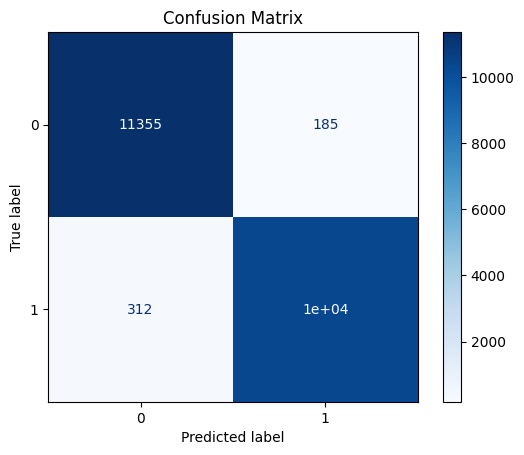

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

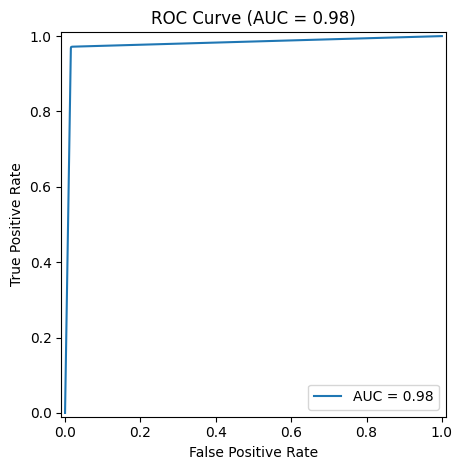

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title(f"ROC Curve (AUC = {roc_auc:.2f})")
plt.tight_layout()
plt.show()

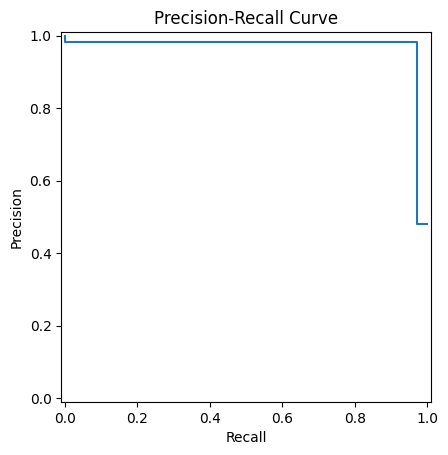

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title("Precision-Recall Curve")
plt.show()

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
0,0.973258,0.983969,0.978584,11540.000000
1,0.982413,0.970693,0.976518,10646.000000
accuracy,0.977598,0.977598,0.977598,0.977598
macro avg,0.977835,0.977331,0.977551,22186.000000
weighted avg,0.977651,0.977598,0.977593,22186.000000


In [ ]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(model, f)